In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 + 2*x + 4

In [3]:
def sigmoid(x):
    return 1/(1+math.exp(-x))

In [4]:
class Value:

    def __init__(self, data, _children = (), _op='', label = ''):
        self.data = data
        self.grad = 0.0 # represents derivative of the parent node with respec to current node
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0*out.grad  # out and self are addresses here, so if it gets executed in outer node then out == currentnode and self and other == children, so even if we are assigning a different address to out in current node, since out was used in this node, out will be current node when executing the function
            other.grad += 1.0*out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other,(int, float))

        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other*self
        return self*other
    
    def __truediv__(self, other):
        return self*other**-1
    
    def __neg__(self):
        return self*-1

    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other

    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2)*out.grad
        out._backward = _backward
        return out
    def sin(self):
        x = self.data
        out = Value(math.sin(x), (self, ), 'sin')
        def _backward():
            self.grad += math.cos(x)*out.grad
        out._backward = _backward
        return out
    def cos(self):
        x = self.data
        out = Value(math.cos(x), (self, ), 'cos')
        def _backward():
            self.grad += -math.sin(x)*out.grad
        out._backward = _backward
        return out
    def tan(self):
        x = self.data
        out = Value(math.tan(x), (self, ), 'tan')
        def _backward():
            self.grad += (1/math.cos(x)**2)*out.grad
        out._backward = _backward
        return out
    def cot(self):
        x = self.data
        out = Value(math.cot(x), (self, ), 'cot')
        def _backward():
            self.grad += -(1/math.sin(x)**2)*out.grad
        out._backward = _backward
        return out
    def sinh(self):
        x = self.data
        out = Value(math.sinh(x), (self, ), 'sinh')
        def _backward():
            self.grad += math.cosh(x)*out.grad
        out._backward = _backward
        return out
    def cosh(self):
        x = self.data
        out = Value(math.cosh(x), (self, ), 'sinh')
        def _backward():
            self.grad += math.sinh(x)*out.grad
        out._backward = _backward
        return out
    

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out

    
    def sigmoid(self):
        x = self.data
        s = sigmoid(x)
        out = Value(s, (self,), 'sigmoid')

        def _backward():
            self.grad += s*(1 - s)*out.grad
        out._backward = _backward
        return out
    def log(self):
        x = self.data
        out = Value(math.log(x), (self,), 'log')

        def _backward():
            self.grad += (1/x)*out.grad
        out._backward = _backward
        return out

    def sinc(self):
        if x == 0:
            print('error 0 not valdid input')
            return  
        x = self.data
        out = Value(math.sinx(x)/x, (self, ), 'sinc')
        def _backward():
            self.grad += ((2*x*math.sin(x) - (x**2)*math.cos(x))/(x**4))*out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        
        visited = set()
        def build_topo(v):
            if v not in visited:
              visited.add(v)
              for child in v._prev:
                build_topo(child)
              topo.append(v)
        build_topo(self)
        self.grad = 1.0
        print(topo)
        for node in reversed(topo):
            node._backward()

In [5]:
a = Value(1) 
b = Value(2)
c = a + b

In [6]:
d = a + b

In [7]:
d = a - c

In [8]:
e = c + d

In [9]:
print(e)

Value(data=1)


In [10]:
print(c, d)

Value(data=3) Value(data=-2)


In [11]:
e.backward()

[Value(data=1), Value(data=2), Value(data=3), Value(data=-1), Value(data=-3), Value(data=-2), Value(data=1)]


In [12]:
d._prev

{Value(data=-3), Value(data=1)}

In [15]:
X = Value(1.0)
Y = Value(2.0)
Z = X + Y

In [19]:
A = Y*X
loss = A+Z

In [6]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [7]:
d._op

'+'

In [16]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR 
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f| grad %.4f }"%(n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

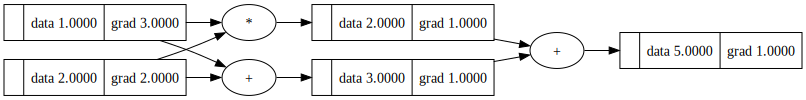

In [22]:
draw_dot(loss)

In [21]:
loss.backward()

[Value(data=1.0), Value(data=2.0), Value(data=3.0), Value(data=2.0), Value(data=5.0)]


In [10]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad*-3
b.grad = e.grad*2
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L

Value(data=-8.0)

In [11]:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'; 


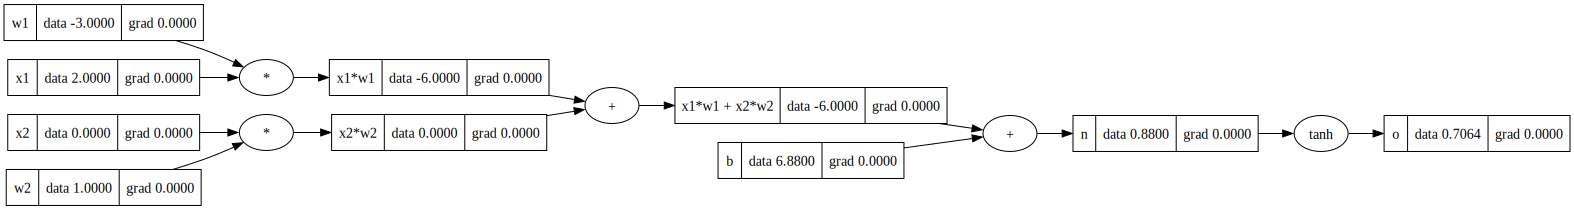

In [12]:
draw_dot(o)

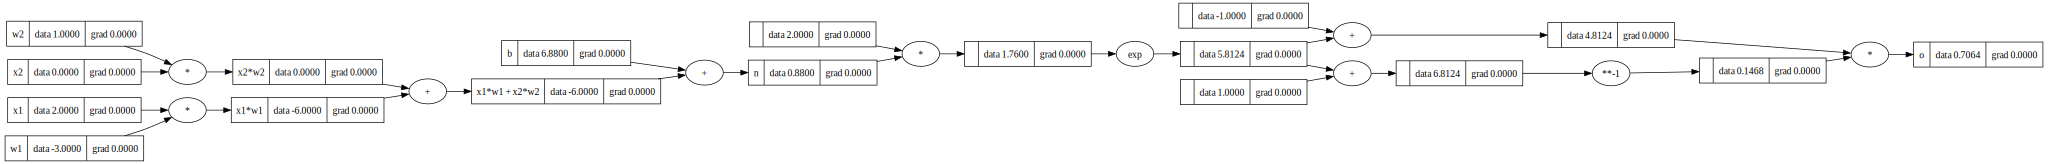

In [13]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label='o'; 
draw_dot(o)

In [14]:
import random
from typing import Any
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def parameters(self):
        return self.w + [self.b]

    def __call__(self, x): # Neuron()(x)

        act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out

In [15]:
from typing import Any


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

In [16]:
x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Value(data=-0.972015211628078),
 Value(data=-0.9667009202526852),
 Value(data=-0.9962890651326991)]

In [17]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

x = [2.0, 3.0, -1.0]

n = MLP(3, [4, 4, 1])

n(x)


Value(data=0.6740124600796654)

In [227]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6231272214795572)

In [217]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [242]:
epochs = 200
learning_rate = 0.05
for k in range(epochs):
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    # resets all the grad to zero for our new weight and biases
    for node in n.parameters():
        node.grad = 0
    # deposits all the gradients in the nodes
    loss.backward()
    # subtracts all the values by a fraction of gradient decent
    for node in n.parameters():
        node.data -= learning_rate*node.grad
    print(k, loss)


0 Value(data=0.0017320769460374423)
1 Value(data=0.0017274093867545703)
2 Value(data=0.0017227659820776382)
3 Value(data=0.0017181465478732874)
4 Value(data=0.0017135509018587531)
5 Value(data=0.001708978863578848)
6 Value(data=0.001704430254383281)
7 Value(data=0.0016999048974041817)
8 Value(data=0.001695402617534144)
9 Value(data=0.0016909232414044238)
10 Value(data=0.0016864665973635906)
11 Value(data=0.0016820325154564121)
12 Value(data=0.0016776208274030635)
13 Value(data=0.0016732313665786488)
14 Value(data=0.0016688639679930553)
15 Value(data=0.001664518468271017)
16 Value(data=0.0016601947056325548)
17 Value(data=0.0016558925198736064)
18 Value(data=0.0016516117523470864)
19 Value(data=0.0016473522459440199)
20 Value(data=0.0016431138450751174)
21 Value(data=0.0016388963956524998)
22 Value(data=0.0016346997450718019)
23 Value(data=0.0016305237421943713)
24 Value(data=0.0016263682373298886)
25 Value(data=0.0016222330822191103)
26 Value(data=0.0016181181300169174)
27 Value(data=0

In [225]:
loss.backward()

In [226]:
for node in n.parameters():
    node.data = -0.001*node.grad
